
# Bayesian inversion on the circular niche

Map the measured horizontal and vertical permeabilities back to the circular tunnel, build a simple random-field prior, and run a Metropolis–Hastings sampler with log-space noise σ=2 (furthest measurements use 10× tighter noise). Priors: background log k ~ N(log(1e-14), 3²) and an explicit lower floor parameter ~ N(log(1e-20), 2²).


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import tunnel_random_field as trf
from niche_geometry import (
    load_niche_segments,
    segments_to_unique_points,
    CircleToPolygonMorpher,
    plot_segments,
)

plt.rcParams.update(
    {
        "figure.figsize": (6.0, 4.0),
        "axes.grid": False,
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "axes.titlesize": 13,
        "axes.labelsize": 12,
        "legend.fontsize": 10,
    }
)

In [12]:
# Measurement depths [m] and permeabilities [m^2]
h_depths = np.array([0.17, 0.31, 0.45, 0.59, 0.73, 0.87, 1.01, 1.15, 1.29, 1.7, 2.5], dtype=float)
h_perm = np.array(
    [
        5e-16,
        2e-16,
        2e-16,
        2e-14,
        5e-16,
        8e-13,
        3e-15,
        8e-16,
        4e-17,
        2e-20,
        5e-21,
    ],
    dtype=float,
)

v_depths = np.array([0.25, 0.35, 0.45, 0.55, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.7, 3.3], dtype=float)
v_perm = np.array(
    [
        2e-17,
        8e-17,
        8e-17,
        8e-15,
        7e-15,
        4e-18,
        6e-18,
        2e-15,
        7e-16,
        9e-17,
        5e-17,
        8e-21,
    ],
    dtype=float,
)

measurement_profiles = {
    "horizontal": {"depths": h_depths, "perm": h_perm},
    "vertical": {"depths": v_depths, "perm": v_perm},
}

orig_points_vertical = np.array(
    [
        [-0.00590468, -1.28667847],
        [-0.00589718, -1.43667847],
        [-0.00589218, -1.53667847],
        [-0.00588718, -1.63667847],
        [-0.00588218, -1.73667847],
        [-0.00587718, -1.83667847],
        [-0.00587218, -1.93667847],
        [-0.00586718, -2.03667847],
        [-0.00586218, -2.13667847],
        [-0.00585718, -2.23667847],
        [-0.00585218, -2.33667847],
        [-0.00584718, -2.43667847],
        [-0.00584218, -2.53667847],
        [-0.00582368, -2.87667847],
        [-0.00578568, -3.65667847],
        [-0.00574768, -4.43667847],
        [-0.00554868, -6.63667847],
        [-0.00554868, -6.63667847],
    ],
    dtype=float,
)

orig_points_horizontal = np.array(
    [
        [1.27414102, -0.16903214],
        [1.4231649, -0.15245487],
        [1.52251415, -0.14140337],
        [1.6218634, -0.13035186],
        [1.72121265, -0.11930035],
        [1.8205619, -0.10824884],
        [1.91991115, -0.09719733],
        [2.0192604, -0.08614582],
        [2.11860965, -0.07509431],
        [2.2179589, -0.0640428],
        [2.31730815, -0.05299129],
        [2.4166574, -0.04193978],
        [2.51600665, -0.03088827],
        [2.96220271, 0.01841753],
        [3.75690169, 0.10680927],
        [4.55160067, 0.19520102],
        [6.73710863, 0.4383037],
        [5.29653465, 0.27805686],
    ],
    dtype=float,
)

p_vert = np.array([-0.00591218, -1.13667847], dtype=float)
p_horiz = np.array([1.12506055, -0.18561569], dtype=float)

# Direction vectors (unit) from the niche boundary into the host rock
d_vert_unit = orig_points_vertical.mean(axis=0) - p_vert
d_vert_unit /= np.linalg.norm(d_vert_unit)

d_horiz_unit = orig_points_horizontal.mean(axis=0) - p_horiz
d_horiz_unit /= np.linalg.norm(d_horiz_unit)

h_coords = p_horiz + np.outer(h_depths, d_horiz_unit)
v_coords = p_vert + np.outer(v_depths, d_vert_unit)

measurement_points_polygon = np.vstack([h_coords, v_coords])
log_perm_obs = np.log(np.concatenate([h_perm, v_perm]))
n_h = h_perm.size
n_v = v_perm.size
color_horizontal = "tab:red"
color_vertical = "k"

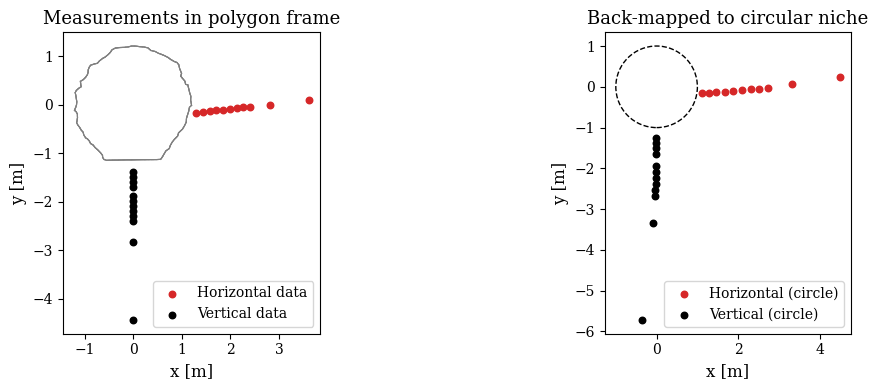

In [13]:
def thin_plate_phi(r: np.ndarray) -> np.ndarray:
    safe_r = np.maximum(r, 1e-12)
    phi = safe_r ** 2 * np.log(safe_r)
    phi[r == 0.0] = 0.0
    return phi


def fit_rbf_weights(src_ctrl: np.ndarray, tgt_ctrl: np.ndarray, regularization: float = 1e-6) -> np.ndarray:
    diff = src_ctrl[:, None, :] - src_ctrl[None, :, :]
    r = np.linalg.norm(diff, axis=2)
    K = thin_plate_phi(r) + regularization * np.eye(r.shape[0])
    disp = tgt_ctrl - src_ctrl
    wx = np.linalg.solve(K, disp[:, 0])
    wy = np.linalg.solve(K, disp[:, 1])
    return np.column_stack([wx, wy])


def make_inverse_transform(morpher: CircleToPolygonMorpher):
    src_ctrl = np.asarray(morpher._tgt_ctrl)
    tgt_ctrl = np.asarray(morpher._src_ctrl)
    weights = fit_rbf_weights(src_ctrl, tgt_ctrl, regularization=morpher.regularization)

    def inverse_transform(points: np.ndarray) -> np.ndarray:
        pts = np.atleast_2d(points)
        diff = pts[:, None, :] - src_ctrl[None, :, :]
        r = np.linalg.norm(diff, axis=2)
        Phi = thin_plate_phi(r)
        disp = Phi @ weights
        warped = pts + disp
        return warped.reshape(points.shape)

    return inverse_transform


niche_segments = load_niche_segments("cd-a_niche4.vtu")
boundary_points = segments_to_unique_points(niche_segments)
morpher = CircleToPolygonMorpher(
    boundary_points,
    circle_radius=1.0,
    n_boundary_ctrl=200,
    n_outer_ctrl=48,
    regularization=5e-6,
)

inverse_polygon_to_circle = make_inverse_transform(morpher)
measurement_points_circle = inverse_polygon_to_circle(measurement_points_polygon)

meas_r = np.linalg.norm(measurement_points_circle, axis=1)
meas_theta = np.mod(
    np.arctan2(measurement_points_circle[:, 1], measurement_points_circle[:, 0]), 2.0 * np.pi
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)
axes[0].scatter(h_coords[:, 0], h_coords[:, 1], s=22, c=color_horizontal, label="Horizontal data")
axes[0].scatter(v_coords[:, 0], v_coords[:, 1], s=22, c=color_vertical, label="Vertical data")
plot_segments(axes[0], niche_segments, color="gray", linewidth=0.8)
axes[0].set_title("Measurements in polygon frame")
axes[0].set_xlabel("x [m]")
axes[0].set_ylabel("y [m]")
axes[0].set_aspect("equal", "box")
axes[0].legend()

axes[1].scatter(
    measurement_points_circle[:n_h, 0],
    measurement_points_circle[:n_h, 1],
    s=22,
    c=color_horizontal,
    label="Horizontal (circle)",
)
axes[1].scatter(
    measurement_points_circle[n_h:, 0],
    measurement_points_circle[n_h:, 1],
    s=22,
    c=color_vertical,
    label="Vertical (circle)",
)
circle = plt.Circle((0.0, 0.0), 1.0, fill=False, color="k", linestyle="--")
axes[1].add_patch(circle)
axes[1].set_title("Back-mapped to circular niche")
axes[1].set_xlabel("x [m]")
axes[1].set_ylabel("y [m]")
axes[1].set_aspect("equal", "box")
axes[1].legend()
plt.tight_layout()

In [14]:
from scipy.optimize import curve_fit


def analyze_profile(depths, permeability, background_depth=1.5):
    depths = np.asarray(depths, dtype=float)
    perm = np.asarray(permeability, dtype=float)
    log_perm = np.log(perm)

    far_mask = depths >= background_depth
    if not np.any(far_mask):
        raise ValueError("Need at least one measurement beyond background_depth")
    mu = float(np.median(log_perm[far_mask]))

    def model(d, A, lam):
        return mu + A * np.exp(-lam * d)

    guess_A = float(np.max(log_perm) - mu)
    popt, _ = curve_fit(
        model,
        depths,
        log_perm,
        p0=(guess_A, 0.5),
        bounds=([0.1, 0.05], [30.0, 3.0]),
    )
    A_hat, lambda_hat = map(float, popt)

    near_mask = depths <= 0.8
    if np.any(near_mask):
        near_mean = float(np.mean(log_perm[near_mask]))
        near_std = float(np.std(log_perm[near_mask], ddof=1)) if near_mask.sum() > 1 else 0.0
    else:
        near_mean = float(np.mean(log_perm))
        near_std = float(np.std(log_perm, ddof=1))

    return {
        "mu": mu,
        "A": A_hat,
        "lambda": lambda_hat,
        "near_mean": near_mean,
        "near_std": near_std,
        "background_depth": background_depth,
    }


profile_params = {}
for name, data in measurement_profiles.items():
    params = analyze_profile(data["depths"], data["perm"], background_depth=1.5)
    profile_params[name] = params

A_values = [params["A"] for params in profile_params.values()]
lambda_values = [params["lambda"] for params in profile_params.values()]

mu_logk_prior = np.log(1e-14)
sigma_logk_prior = 3.0
mu_floor_prior = np.log(1e-20)
sigma_floor_prior = 2.0
obs_noise_sigma = 1.0
noise_sigma_all = np.full(n_h + n_v, obs_noise_sigma)
noise_sigma_all[n_h - 1] = obs_noise_sigma / 2.0  # farthest horizontal point
noise_sigma_all[-1] = obs_noise_sigma / 2.0       # farthest vertical point

ell_A = 0.7
ell_lambda = 2.2
sigma_A_field = 1.0
sigma_lambda_field = 1.0
mu_A = float(np.mean(A_values))
sigma_A = max(4.5, float(np.std(A_values, ddof=1)))
lambda0 = float(np.mean(lambda_values))
sigma_log_lambda = max(0.25, float(np.std(np.log(lambda_values), ddof=1)))

print(f"Background log k prior mean: {mu_logk_prior:.3f} (~{np.exp(mu_logk_prior):.2e} m^2)")
print(f"Observation noise σ (log-space): {obs_noise_sigma}")
print("Circle-field hyperparameters:")
print(f"  mu_A={mu_A:.3f}, sigma_A={sigma_A:.3f}, ell_A={ell_A}")
print(f"  lambda0={lambda0:.3f}, sigma_log_lambda={sigma_log_lambda:.3f}, ell_lambda={ell_lambda}")
print(f"  Floor prior mean ~{np.exp(mu_floor_prior):.1e} m^2 (σ={sigma_floor_prior})")

Background log k prior mean: -32.236 (~1.00e-14 m^2)
Observation noise σ (log-space): 1.0
Circle-field hyperparameters:
  mu_A=11.426, sigma_A=5.454, ell_A=0.7
  lambda0=0.490, sigma_log_lambda=0.250, ell_lambda=2.2
  Floor prior mean ~1.0e-20 m^2 (σ=2.0)


In [15]:
rng = np.random.default_rng(2026)

n_theta = 720
theta_grid = np.linspace(0.0, 2.0 * np.pi, n_theta, endpoint=False)
R_tunnel = 1.0

n_modes_A = 6
n_modes_lambda = 6
dim_A = 1 + 2 * n_modes_A
dim_lambda = 1 + 2 * n_modes_lambda
dim_total = dim_A + dim_lambda + 2  # +2 for log_k0 and log_floor


def kl_field_from_coeffs(coeffs, ell, sigma_field, n_modes, theta_grid, L=2.0 * np.pi):
    coeffs = np.asarray(coeffs, dtype=float)
    lam = trf.kl_eigenvalues_exponential_periodic(ell, sigma_field, n_modes, L=L)
    u = np.zeros_like(theta_grid)
    phi0 = 1.0 / np.sqrt(L)
    u += np.sqrt(lam[0]) * coeffs[0] * phi0
    idx = 1
    for n in range(1, n_modes + 1):
        lam_n = lam[n]
        k = 2.0 * np.pi * n / L
        phi_c = np.sqrt(2.0 / L) * np.cos(k * theta_grid)
        phi_s = np.sqrt(2.0 / L) * np.sin(k * theta_grid)
        xi_c, xi_s = coeffs[idx], coeffs[idx + 1]
        u += np.sqrt(lam_n) * (xi_c * phi_c + xi_s * phi_s)
        idx += 2
    return u


def unpack(theta_vec):
    xi_A = theta_vec[:dim_A]
    xi_lambda = theta_vec[dim_A : dim_A + dim_lambda]
    log_k0 = theta_vec[-2]
    log_floor = theta_vec[-1]
    return xi_A, xi_lambda, log_k0, log_floor


def circle_fields_from_theta(theta_vec):
    xi_A, xi_lambda, log_k0, log_floor = unpack(theta_vec)
    u_A = kl_field_from_coeffs(xi_A, ell_A, sigma_A_field, n_modes_A, theta_grid)
    A_theta = mu_A + sigma_A * u_A
    u_lambda = kl_field_from_coeffs(
        xi_lambda, ell_lambda, sigma_lambda_field, n_modes_lambda, theta_grid
    )
    lambda_theta = np.exp(np.log(lambda0) + sigma_log_lambda * u_lambda)
    return A_theta, lambda_theta, log_k0, log_floor


def predict_logk(theta_vec):
    A_theta, lambda_theta, log_k0, log_floor = circle_fields_from_theta(theta_vec)
    A_at_data = np.interp(meas_theta, theta_grid, A_theta, period=2.0 * np.pi)
    lambda_at_data = np.interp(meas_theta, theta_grid, lambda_theta, period=2.0 * np.pi)
    dr = np.maximum(meas_r - R_tunnel, 0.0)
    logk_vals = log_k0 + A_at_data * np.exp(-lambda_at_data * dr)
    return np.maximum(log_floor, logk_vals)


def log_prior(theta_vec):
    xi_A, xi_lambda, log_k0, log_floor = unpack(theta_vec)
    lp = -0.5 * np.dot(xi_A, xi_A) - 0.5 * np.dot(xi_lambda, xi_lambda)
    lp += -0.5 * ((log_k0 - mu_logk_prior) / sigma_logk_prior) ** 2
    lp += -0.5 * ((log_floor - mu_floor_prior) / sigma_floor_prior) ** 2
    return lp


def log_likelihood(theta_vec):
    pred = predict_logk(theta_vec)
    resid = log_perm_obs - pred
    return -0.5 * np.sum((resid / noise_sigma_all) ** 2)


def log_posterior(theta_vec):
    return log_prior(theta_vec) + log_likelihood(theta_vec)


theta_init = np.zeros(dim_total)
theta_init[-2] = mu_logk_prior
theta_init[-1] = mu_floor_prior

In [16]:
def smooth_curve(depths, values, n=600, dmin=0.0, dmax=3.5):
    depths = np.asarray(depths, dtype=float)
    values = np.asarray(values, dtype=float)
    grid = np.linspace(dmin, dmax, int(n))
    log_vals = np.interp(grid, depths, np.log(values))
    return grid, np.exp(log_vals)

def line_logk(depths, A_theta, lambda_theta, log_k0, log_floor, base_point, dir_unit):
    coords = base_point + np.outer(depths, dir_unit)
    coords_circle = inverse_polygon_to_circle(coords)
    r = np.linalg.norm(coords_circle, axis=1)
    theta = np.mod(np.arctan2(coords_circle[:, 1], coords_circle[:, 0]), 2.0 * np.pi)
    A_line = np.interp(theta, theta_grid, A_theta, period=2.0 * np.pi)
    lambda_line = np.interp(theta, theta_grid, lambda_theta, period=2.0 * np.pi)
    dr = np.maximum(r - R_tunnel, 0.0)
    logk = log_k0 + A_line * np.exp(-lambda_line * dr)
    return np.maximum(log_floor, logk)

In [17]:
def metropolis_hastings(
    log_post,
    theta_init: np.ndarray,
    n_samples: int,
    proposal_std: float,
    burnin: int = 0,
    thinning: int = 1,
    random_state=None,
):
    theta_curr = np.asarray(theta_init, dtype=float)
    dim = theta_curr.size

    if isinstance(random_state, np.random.Generator):
        rng_local = random_state
    else:
        rng_local = np.random.default_rng(random_state)

    logp_curr = log_post(theta_curr)
    total_needed = burnin + n_samples * thinning

    samples = np.zeros((n_samples, dim))
    log_posts = np.zeros(n_samples)
    accepts = 0
    kept = 0

    for step in range(total_needed):
        proposal = theta_curr + proposal_std * rng_local.standard_normal(size=dim)
        logp_prop = log_post(proposal)

        log_alpha = logp_prop - logp_curr
        if np.log(rng_local.uniform()) < log_alpha:
            theta_curr = proposal
            logp_curr = logp_prop
            accepts += 1

        if step >= burnin and (step - burnin) % thinning == 0:
            samples[kept, :] = theta_curr
            log_posts[kept] = logp_curr
            kept += 1

    accept_rate = accepts / float(total_needed)
    return samples, log_posts, accept_rate


n_samples = 35000
proposal_std = 0.35

samples, log_posts, acc_rate = metropolis_hastings(
    log_post=log_posterior,
    theta_init=theta_init,
    n_samples=n_samples,
    proposal_std=proposal_std,
    burnin=1200,
    thinning=2,
    random_state=rng,
)

map_idx = int(np.argmax(log_posts))
theta_map = samples[map_idx]

print(f"Posterior samples: {samples.shape}")
print(f"Acceptance rate: {acc_rate:.3f}")
print(f"MAP log-posterior: {log_posts[map_idx]:.2f}")

Posterior samples: (35000, 28)
Acceptance rate: 0.027
MAP log-posterior: -175.04


MAP background log k: -51.69 (~3.54e-23 m^2)
MAP floor log k:      -48.06 (~1.34e-21 m^2)


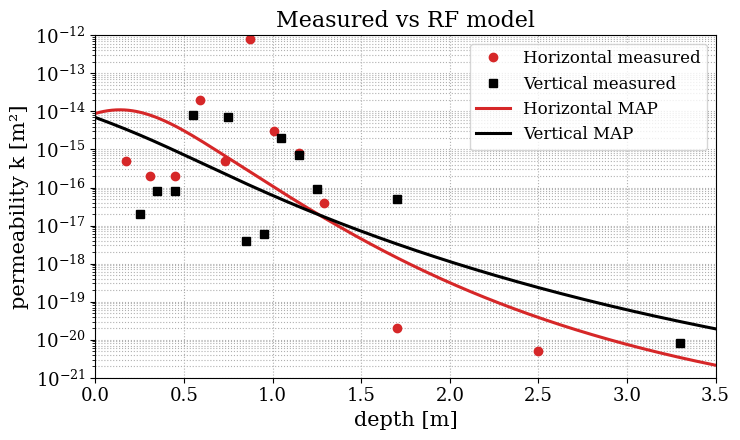

In [18]:
A_map, lambda_map, log_k0_map, log_floor_map = circle_fields_from_theta(theta_map)
log_pred_map = predict_logk(theta_map)
perm_pred_map = np.exp(log_pred_map)
perm_obs = np.exp(log_perm_obs)

print(f"MAP background log k: {log_k0_map:.2f} (~{np.exp(log_k0_map):.2e} m^2)")
print(f"MAP floor log k:      {log_floor_map:.2f} (~{np.exp(log_floor_map):.2e} m^2)")

depth_line = np.linspace(0.0, 3.5, 600)
log_h_line_map = line_logk(depth_line, A_map, lambda_map, log_k0_map, log_floor_map, p_horiz, d_horiz_unit)
log_v_line_map = line_logk(depth_line, A_map, lambda_map, log_k0_map, log_floor_map, p_vert, d_vert_unit)

fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.semilogy(h_depths, h_perm, "o", color=color_horizontal, label="Horizontal measured")
ax.semilogy(v_depths, v_perm, "s", color=color_vertical, label="Vertical measured")
ax.semilogy(depth_line, np.exp(log_h_line_map), "-", color=color_horizontal, linewidth=2.2, label="Horizontal MAP")
ax.semilogy(depth_line, np.exp(log_v_line_map), "-", color=color_vertical, linewidth=2.2, label="Vertical MAP")

ax.set_xlim(0.0, 3.5)
ax.set_ylim(1e-21, 1e-12)
ax.set_xlabel("depth [m]", fontsize=15)
ax.set_ylabel("permeability k [m²]", fontsize=15)
ax.set_title("Measured vs RF model", fontsize=16)
ax.tick_params(labelsize=13)
ax.grid(True, which="both", linestyle=":", linewidth=0.8)
ax.legend(fontsize=12)

plt.tight_layout()

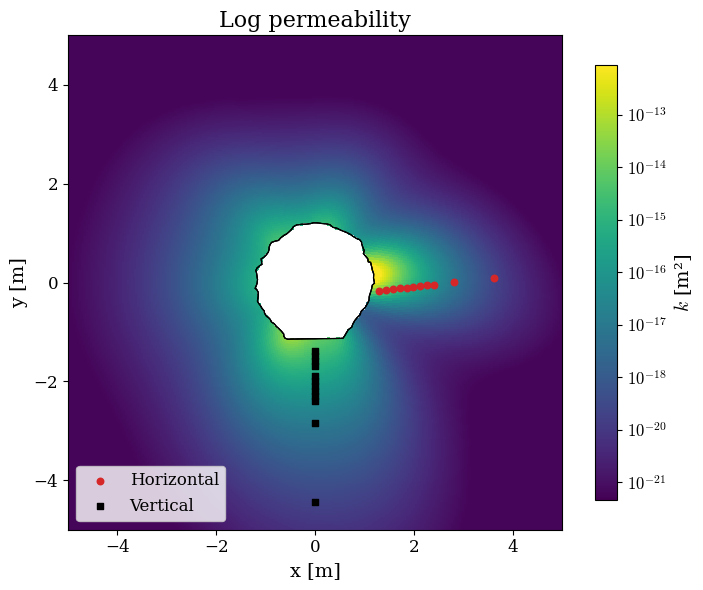

In [19]:
def log10_formatter(val, pos):
    exp10 = val / np.log(10.0)
    return rf"$10^{{{exp10:.0f}}}$"


log_k_map, x, y = trf.build_tunnel_logk_field(
    theta_circle=theta_grid,
    A_theta=A_map,
    lambda_theta=lambda_map,
    xlim=(-8.0, 8.0),
    ylim=(-8.0, 8.0),
    nx=320,
    ny=320,
    R_tunnel=R_tunnel,
    mu_logk=log_k0_map,
    mask_inside=True,
)

finite_mask = np.isfinite(log_k_map)
log_k_map = np.where(finite_mask, np.maximum(log_floor_map, log_k_map), np.nan)

log_vmin_vis = np.log(1e-21)
log_vmax_vis = np.log(1e-12)
log_k_map = np.clip(log_k_map, log_vmin_vis, log_vmax_vis)

Xw, Yw = morpher.warp_grid(x, y)
vmin, vmax = log_vmin_vis, log_vmax_vis

fig, ax = plt.subplots(figsize=(7.5, 6.0))
pcm = ax.pcolormesh(Xw, Yw, log_k_map, shading="auto", vmin=vmin, vmax=vmax)
plot_segments(ax, niche_segments, color="k", linewidth=0.8)

ax.scatter(
    h_coords[:, 0],
    h_coords[:, 1],
    s=22,
    color=color_horizontal,
    marker="o",
    label="Horizontal",
    zorder=3,
)
ax.scatter(
    v_coords[:, 0],
    v_coords[:, 1],
    s=22,
    color=color_vertical,
    marker="s",
    label="Vertical",
    zorder=3,
)

ax.set_aspect("equal", "box")
ax.set_xlim(-5.0, 5.0)
ax.set_ylim(-5.0, 5.0)
ax.set_title("Log permeability", fontsize=16)
ax.set_xlabel("x [m]", fontsize=14)
ax.set_ylabel("y [m]", fontsize=14)
ax.tick_params(labelsize=12)
ax.legend(loc="lower left", fontsize=12)

cbar = fig.colorbar(pcm, ax=ax, shrink=0.88)
cbar.set_label(r"$k$ [m²]", fontsize=14)
cbar.ax.tick_params(labelsize=12)
cbar.formatter = FuncFormatter(log10_formatter)
cbar.update_ticks()

plt.tight_layout()


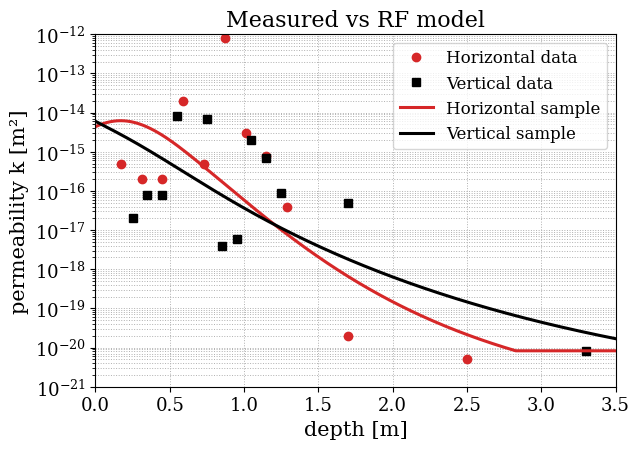

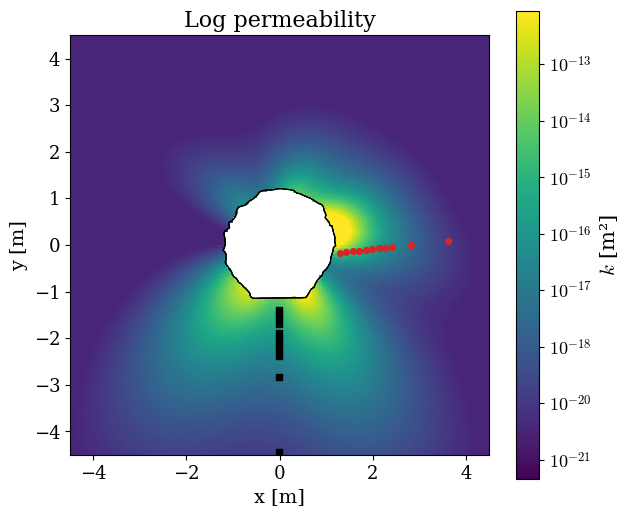

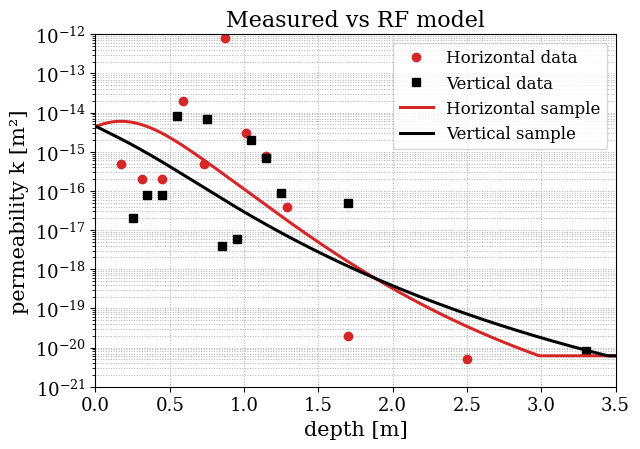

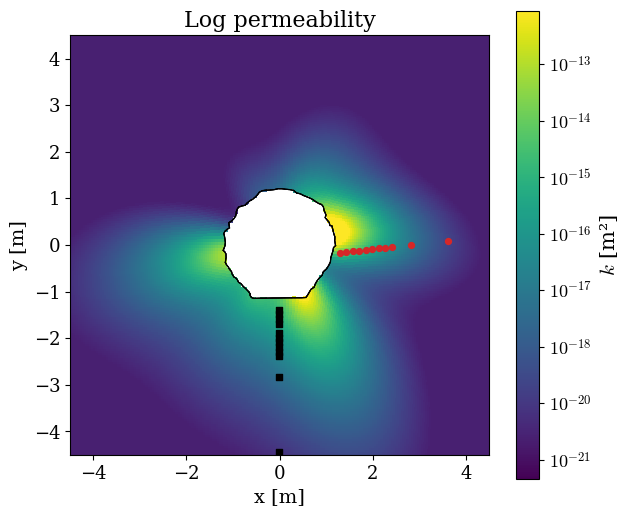

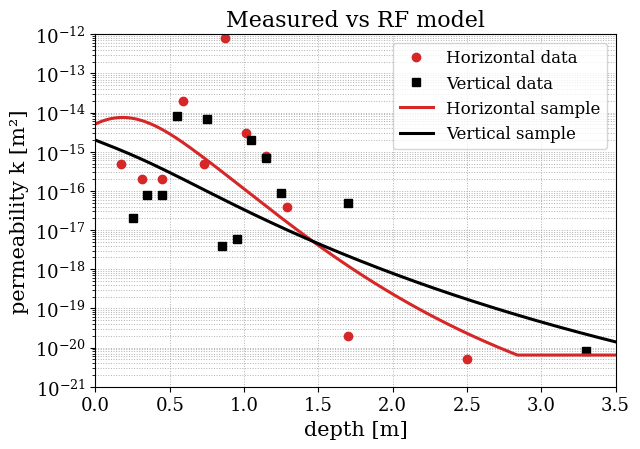

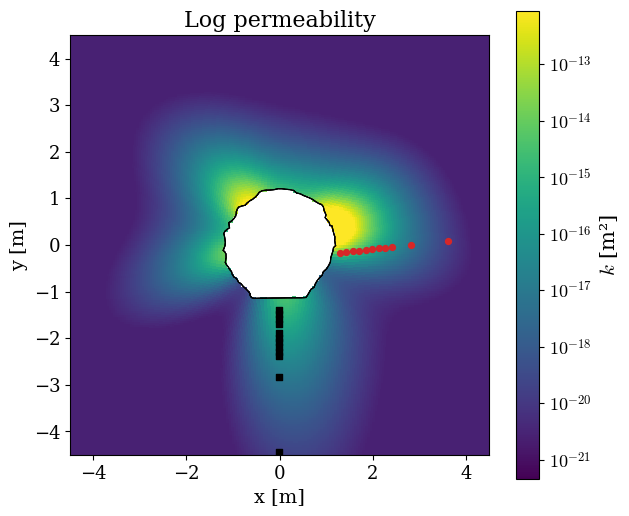

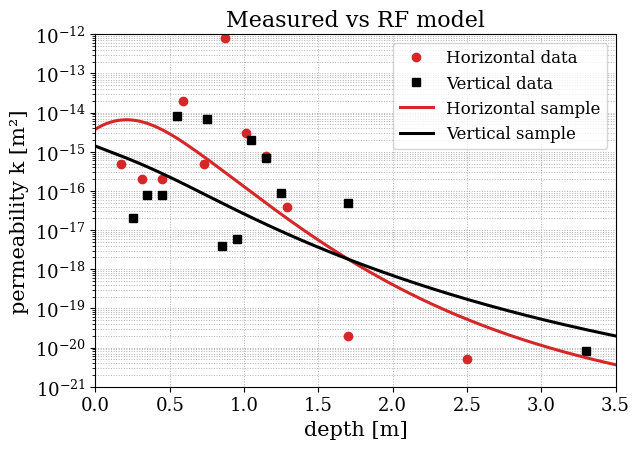

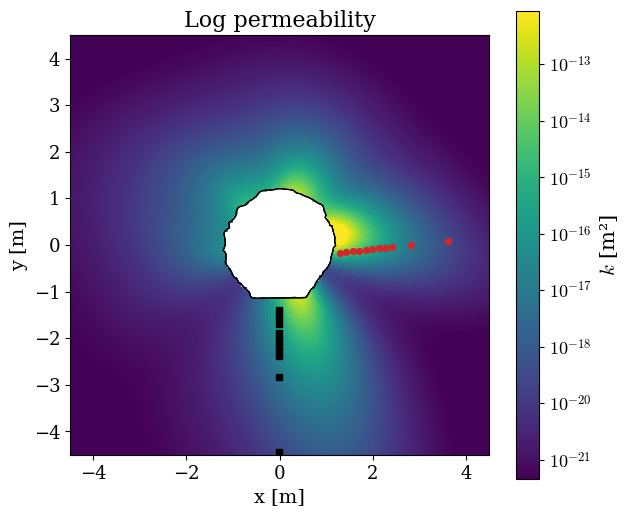

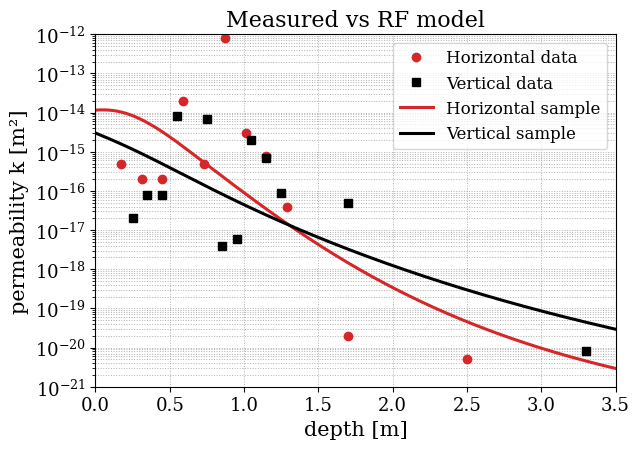

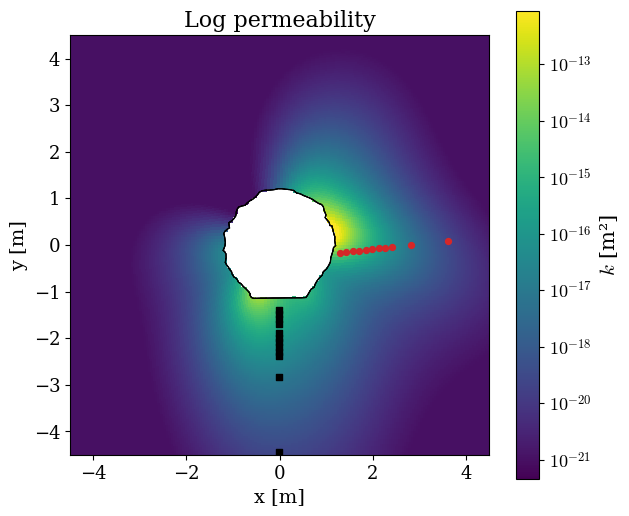

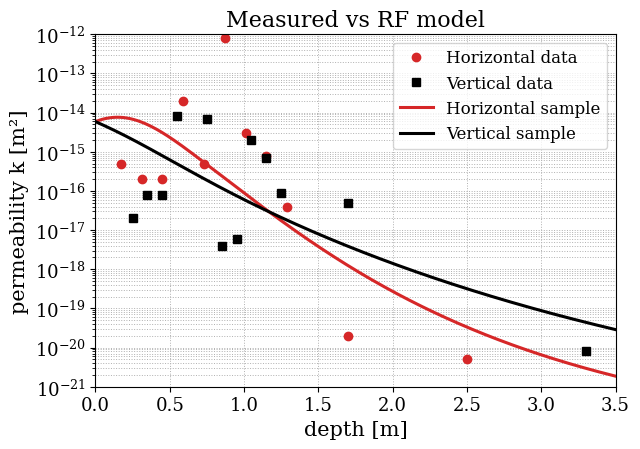

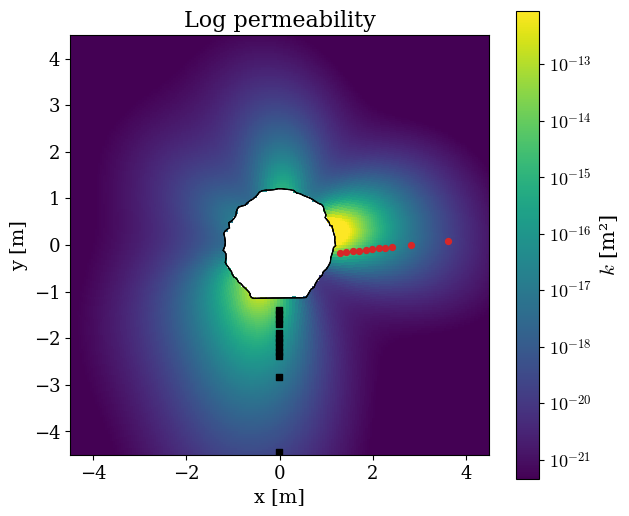

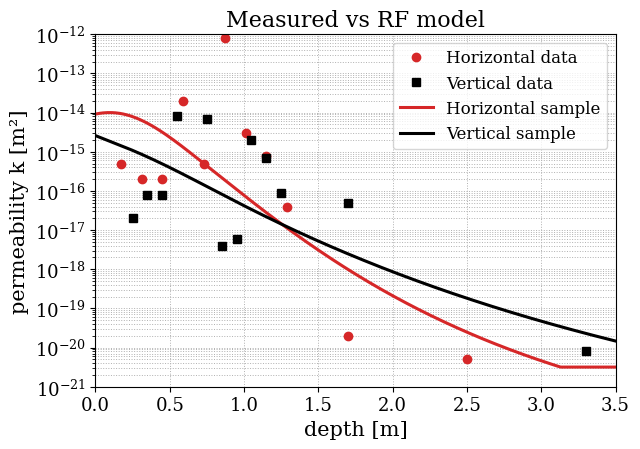

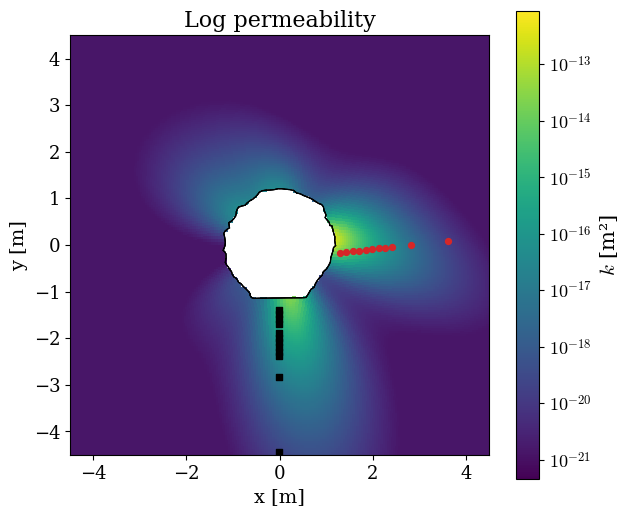

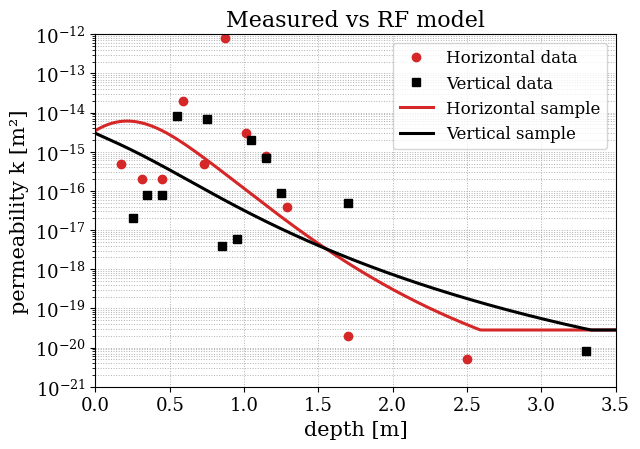

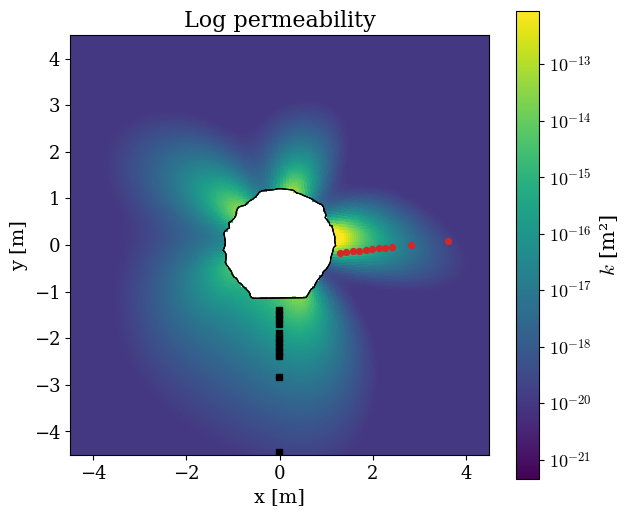

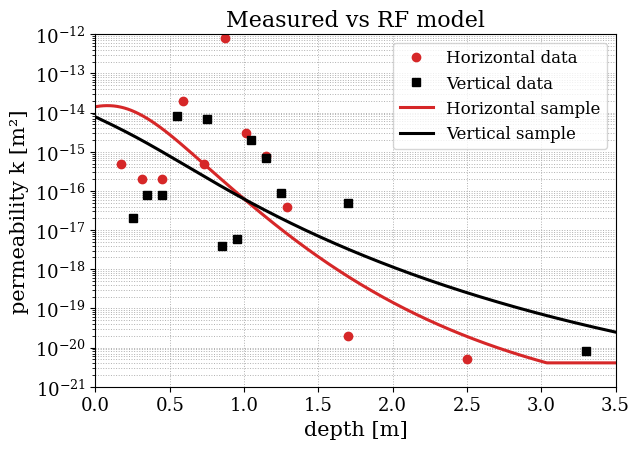

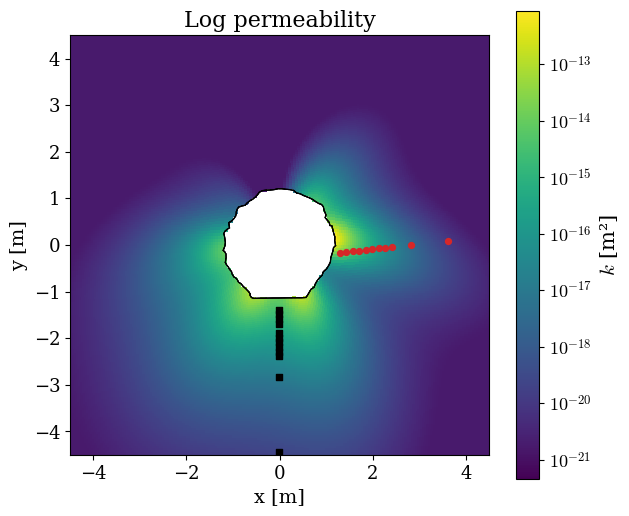

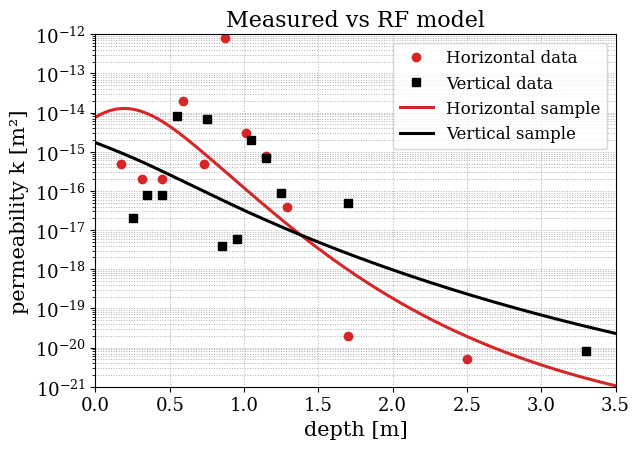

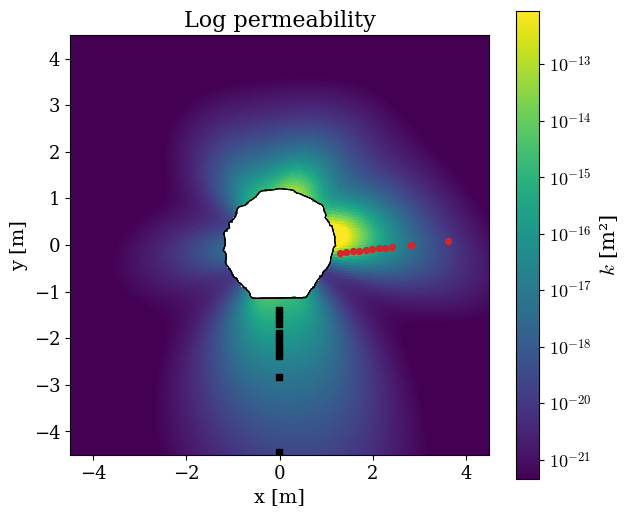

In [20]:
# Show additional samples from the chain (fits + warped fields)
depth_line = np.linspace(0.0, 3.5, 600)
n_show = 10
idx_show = np.linspace(0, samples.shape[0] - 1, n_show, dtype=int)

for j, idx in enumerate(idx_show, start=1):
    theta_s = samples[idx]
    A_s, lambda_s, log_k0_s, log_floor_s = circle_fields_from_theta(theta_s)
    perm_pred_s = np.exp(predict_logk(theta_s))

    log_h_line_s = line_logk(depth_line, A_s, lambda_s, log_k0_s, log_floor_s, p_horiz, d_horiz_unit)
    log_v_line_s = line_logk(depth_line, A_s, lambda_s, log_k0_s, log_floor_s, p_vert, d_vert_unit)

    fig_fit, ax_fit = plt.subplots(figsize=(6.5, 4.6))
    ax_fit.semilogy(h_depths, h_perm, "o", color=color_horizontal, label="Horizontal data")
    ax_fit.semilogy(v_depths, v_perm, "s", color=color_vertical, label="Vertical data")
    ax_fit.semilogy(depth_line, np.exp(log_h_line_s), "-", color=color_horizontal, linewidth=2.2, label="Horizontal sample")
    ax_fit.semilogy(depth_line, np.exp(log_v_line_s), "-", color=color_vertical, linewidth=2.2, label="Vertical sample")
    ax_fit.set_xlim(0.0, 3.5)
    ax_fit.set_ylim(1e-21, 1e-12)
    ax_fit.set_xlabel("depth [m]", fontsize=15)
    ax_fit.set_ylabel("permeability k [m²]", fontsize=15)
    ax_fit.set_title("Measured vs RF model", fontsize=16)
    ax_fit.grid(True, which="both", linestyle=":", linewidth=0.7)
    ax_fit.tick_params(labelsize=13)
    ax_fit.legend(fontsize=12)
    fig_fit.tight_layout()

    log_k_s, x_s, y_s = trf.build_tunnel_logk_field(
        theta_circle=theta_grid,
        A_theta=A_s,
        lambda_theta=lambda_s,
        xlim=(-7.0, 7.0),
        ylim=(-7.0, 7.0),
        nx=240,
        ny=240,
        R_tunnel=R_tunnel,
        mu_logk=log_k0_s,
        mask_inside=True,
    )

    finite_mask_s = np.isfinite(log_k_s)
    log_k_s = np.where(finite_mask_s, np.maximum(log_floor_s, log_k_s), np.nan)
    log_k_s = np.clip(log_k_s, log_vmin_vis, log_vmax_vis)
    Xws, Yws = morpher.warp_grid(x_s, y_s)
    vmins, vmaxs = log_vmin_vis, log_vmax_vis

    fig_field, ax_field = plt.subplots(figsize=(6.4, 6.0))
    pcm = ax_field.pcolormesh(Xws, Yws, log_k_s, shading="auto", vmin=vmins, vmax=vmaxs)
    plot_segments(ax_field, niche_segments, color="k", linewidth=0.8)
    ax_field.scatter(h_coords[:, 0], h_coords[:, 1], s=18, color=color_horizontal, marker="o", zorder=3)
    ax_field.scatter(v_coords[:, 0], v_coords[:, 1], s=18, color=color_vertical, marker="s", zorder=3)
    ax_field.set_aspect("equal", "box")
    ax_field.set_xlim(-4.5, 4.5)
    ax_field.set_ylim(-4.5, 4.5)
    ax_field.set_title("Log permeability", fontsize=16)
    ax_field.set_xlabel("x [m]", fontsize=14)
    ax_field.set_ylabel("y [m]", fontsize=14)
    ax_field.tick_params(labelsize=13)

    cbar = fig_field.colorbar(pcm, ax=ax_field, shrink=0.85)
    cbar.set_label(r"$k$ [m²]", fontsize=15)
    cbar.ax.tick_params(labelsize=13)
    cbar.formatter = FuncFormatter(log10_formatter)
    cbar.update_ticks()

    fig_field.tight_layout()